In [ ]:
!pip -q install kagglehub xgboost fairlearn aif360 scikit-learn pandas numpy matplotlib statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 47.2 MB/s eta 0:00:00


In [ ]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
from kagglehub import KaggleDatasetAdapter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from xgboost import XGBClassifier

from fairlearn.metrics import demographic_parity_difference, equal_opportunity_difference
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.postprocessing import ThresholdOptimizer

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

from statsmodels.stats.contingency_tables import mcnemar


pip install 'aif360[inFairness]'


In [ ]:
# Download resume dataset (2025)
resume_path = kagglehub.dataset_download("mdtalhask/ai-powered-resume-screening-dataset-2025")
print("Resume dataset path:", resume_path)

# Find CSV
resume_csvs = glob.glob(os.path.join(resume_path, "*.csv"))
print("Resume CSVs:", resume_csvs)

df_resumes = pd.read_csv(resume_csvs[0])
print("Resumes shape:", df_resumes.shape)
df_resumes.head()


100%|██████████| 22.8k/22.8k [00:00<00:00, 19.7MB/s]

Extracting files...
Resume dataset path: /root/.cache/kagglehub/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025/versions/1
Resume CSVs: ['/root/.cache/kagglehub/datasets/mdtalhask/ai-powered-resume-screening-dataset-2025/versions/1/AI_Resume_Screening.csv']
Resumes shape: (1000, 11)


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100)
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70
3,4,Elizabeth Carney,"Python, Pytorch, TensorFlow",7,B.Tech,AWS Certified,AI Researcher,Hire,46848,0,95
4,5,Julie Hill,"SQL, React, Java",4,PhD,NaN,Software Engineer,Hire,87441,9,100


In [ ]:
df_resumes = df_resumes.copy()
df_resumes.columns = [c.strip().lower().replace(" ", "_") for c in df_resumes.columns]
print(df_resumes.columns.tolist())

# Ensure label exists: y (Hire=1, Reject=0)
# If recruiter_decision exists, map it
if "y" not in df_resumes.columns:
    df_resumes["recruiter_decision"] = df_resumes["recruiter_decision"].astype(str).str.lower().str.strip()
    df_resumes["y"] = df_resumes["recruiter_decision"].map({"hire": 1, "reject": 0})

df_resumes = df_resumes.dropna(subset=["y"]).copy()
df_resumes["y"] = df_resumes["y"].astype(int)

# Create numeric features if not present already
def count_list_items(x):
    if pd.isna(x):
        return 0
    parts = re.split(r"[,;|/]+", str(x))
    parts = [p.strip() for p in parts if p.strip()]
    return len(parts)

# skills_count
if "skills_count" not in df_resumes.columns:
    df_resumes["skills_count"] = df_resumes["skills"].apply(count_list_items)

# education_level ordinal
edu_map = {
    "high school": 1, "bachelor": 2, "bachelors": 2, "b.sc": 2, "bsc": 2, "b.tech": 2, "btech": 2,
    "master": 3, "masters": 3, "mba": 3, "m.tech": 3, "mtech": 3,
    "phd": 4, "doctorate": 4
}

def encode_edu(x):
    if pd.isna(x):
        return 0
    t = str(x).lower()
    for k, v in edu_map.items():
        if k in t:
            return v
    return 0

if "education_level" not in df_resumes.columns:
    df_resumes["education_level"] = df_resumes["education"].apply(encode_edu)

# certification_count
if "certification_count" not in df_resumes.columns:
    cert_col = "certifications" if "certifications" in df_resumes.columns else None
    df_resumes["certification_count"] = df_resumes[cert_col].apply(count_list_items) if cert_col else 0

# experience_years
if "experience_years" not in df_resumes.columns:
    if "experience_(years)" in df_resumes.columns:
        df_resumes["experience_years"] = pd.to_numeric(df_resumes["experience_(years)"], errors="coerce").fillna(0)
    elif "experience_years" in df_resumes.columns:
        df_resumes["experience_years"] = pd.to_numeric(df_resumes["experience_years"], errors="coerce").fillna(0)
    else:
        df_resumes["experience_years"] = 0

# projects_count
if "projects_count" in df_resumes.columns:
    df_resumes["projects_count"] = pd.to_numeric(df_resumes["projects_count"], errors="coerce").fillna(0)
else:
    df_resumes["projects_count"] = 0

# ai_score
if "ai_score" not in df_resumes.columns:
    if "ai_score_(0-100)" in df_resumes.columns:
        df_resumes["ai_score"] = pd.to_numeric(df_resumes["ai_score_(0-100)"], errors="coerce").fillna(0)
    else:
        df_resumes["ai_score"] = 0

df_resumes[["skills_count","education_level","certification_count","experience_years","projects_count","ai_score","y"]].head()


['resume_id', 'name', 'skills', 'experience_(years)', 'education', 'certifications', 'job_role', 'recruiter_decision', 'salary_expectation_($)', 'projects_count', 'ai_score_(0-100)']


,skills_count,education_level,certification_count,experience_years,projects_count,ai_score,y
0,3,2,0,10,8,100,1
1,4,3,1,10,1,100,1
2,3,3,1,1,7,70,1
3,3,2,1,7,0,95,1
4,3,4,0,4,9,100,1


In [ ]:
df_resumes = df_resumes.sample(frac=1.0, random_state=42).reset_index(drop=True)

# gender: 0/1 balanced
df_resumes["gender"] = np.array([0, 1] * (len(df_resumes)//2) + ([0] if len(df_resumes)%2 else []))

# race_gender: 8-group balanced assignment
groups = ["White_M","White_F","Black_M","Black_F","Asian_M","Asian_F","Hispanic_M","Hispanic_F"]
df_resumes["race_gender"] = [groups[i % len(groups)] for i in range(len(df_resumes))]

df_resumes[["gender","race_gender"]].value_counts().head()


gender  race_gender
0       Asian_M        125
        Black_M        125
        Hispanic_M     125
        White_M        125
1       Asian_F        125
Name: count, dtype: int64

In [ ]:
jd_path = kagglehub.dataset_download("kshitizregmi/jobs-and-job-description")

100%|██████████| 1.48M/1.48M [00:00<00:00, 96.8MB/s]

Extracting files...


In [ ]:
import os, glob
import kagglehub

jd_path = kagglehub.dataset_download("kshitizregmi/jobs-and-job-description")
print("JD dataset path:", jd_path)

csv_files = glob.glob(os.path.join(jd_path, "*.csv"))
print("CSV files:", csv_files)

df_jd = pd.read_csv(csv_files[0])
df_jd.head()


Using Colab cache for faster access to the 'jobs-and-job-description' dataset.
JD dataset path: /kaggle/input/jobs-and-job-description
CSV files: ['/kaggle/input/jobs-and-job-description/job_title_des.csv']


,Unnamed: 0,Job Title,Job Description
0,0,Flutter Developer,We are looking for hire experts flutter develo...
1,1,Django Developer,PYTHON/DJANGO (Developer/Lead) - Job Code(PDJ ...
2,2,Machine Learning,"Data Scientist (Contractor)\n\nBangalore, IN\n..."
3,3,iOS Developer,JOB DESCRIPTION:\n\nStrong framework outside o...
4,4,Full Stack Developer,job responsibility full stack engineer – react...


In [ ]:
df = df_resumes.copy()


df["job_role_clean"] = df["job_role"].astype(str).str.lower().str.strip()


possible_title_cols = ["Job Title", "job_title", "title", "Position", "position"]
possible_desc_cols  = ["Job Description", "job_description", "description", "Job_Description"]

title_col = next((c for c in df_jd.columns if c in possible_title_cols), None)
desc_col  = next((c for c in df_jd.columns if c in possible_desc_cols), None)

print("Detected title_col:", title_col)
print("Detected desc_col:", desc_col)

df_jd_clean = df_jd.copy()
df_jd_clean["job_title_clean"] = df_jd_clean[title_col].astype(str).str.lower().str.strip()


df_jd_small = (
    df_jd_clean.dropna(subset=[desc_col])
              .groupby("job_title_clean", as_index=False)
              .first()[["job_title_clean", desc_col]]
)


df = df.merge(df_jd_small, left_on="job_role_clean", right_on="job_title_clean", how="left")
df.rename(columns={desc_col: "jd_text"}, inplace=True)

df["jd_text"] = df["jd_text"].fillna(
    "Looking for candidates with relevant skills, experience, and qualifications for this role."
)

df[["job_role", "jd_text"]].head()


Detected title_col: Job Title
Detected desc_col: Job Description


,job_role,jd_text
0,AI Researcher,"Looking for candidates with relevant skills, e..."
1,Cybersecurity Analyst,"Looking for candidates with relevant skills, e..."
2,AI Researcher,"Looking for candidates with relevant skills, e..."
3,Software Engineer,"Overview\n\n\nBased in Silicon Valley, Tintri ..."
4,Cybersecurity Analyst,"Looking for candidates with relevant skills, e..."


In [ ]:
def tokenize(text):
    text = str(text).lower()
    return set(re.findall(r"[a-zA-Z\+\#\.]+", text))

def skills_match(resume_skills, jd_text):
    r = tokenize(resume_skills)
    j = tokenize(jd_text)
    if len(j) == 0:
        return 0.0
    return len(r.intersection(j)) / len(j)

df["skills_match_score"] = df.apply(lambda row: skills_match(row["skills"], row["jd_text"]), axis=1)
df["resume_keywords_count"] = df["skills"].apply(lambda x: len(tokenize(x)))
df["jd_keywords_count"] = df["jd_text"].apply(lambda x: len(tokenize(x)))

# TF-IDF similarity
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
resume_text = df["skills"].fillna("").astype(str)
jd_text = df["jd_text"].fillna("").astype(str)

tfidf_matrix = tfidf.fit_transform(resume_text.tolist() + jd_text.tolist())
resume_vecs = tfidf_matrix[:len(df)]
jd_vecs = tfidf_matrix[len(df):]

df["tfidf_similarity"] = cosine_similarity(resume_vecs, jd_vecs).diagonal()

df[["skills_match_score","resume_keywords_count","jd_keywords_count","tfidf_similarity"]].head()


,skills_match_score,resume_keywords_count,jd_keywords_count,tfidf_similarity
0,0.0,3,11,0.0
1,0.0,3,11,0.0
2,0.0,3,11,0.0
3,0.0,2,234,0.0
4,0.0,2,11,0.0


In [ ]:
FEATURES = [
    "skills_count","education_level","certification_count",
    "experience_years","projects_count","ai_score",
    "skills_match_score","resume_keywords_count","jd_keywords_count","tfidf_similarity"
]

TARGET = "y"
PROTECTED = "gender"

X = df[FEATURES].copy()
y = df[TARGET].astype(int).copy()
A = df[PROTECTED].copy()

X_train, X_temp, y_train, y_temp, A_train, A_temp = train_test_split(
    X, y, A, test_size=0.30, random_state=42, stratify=A
)

X_val, X_test, y_val, y_test, A_val, A_test = train_test_split(
    X_temp, y_temp, A_temp, test_size=0.50, random_state=42, stratify=A_temp
)

# Reset indices to avoid alignment issues
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
A_train = A_train.reset_index(drop=True)

X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)
A_test  = A_test.reset_index(drop=True)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (700, 10) Test: (150, 10)


In [ ]:
def selection_rate_by_group(y_pred, A):
    y_pred = np.asarray(y_pred)
    A = np.asarray(A)
    rates = {}
    for g in np.unique(A):
        mask = (A == g)
        rates[g] = float((y_pred[mask] == 1).mean()) if mask.sum() > 0 else np.nan
    return rates

def impact_ratio(y_pred, A):
    rates = selection_rate_by_group(y_pred, A)
    vals = [v for v in rates.values() if not np.isnan(v)]
    if len(vals) < 2:
        return np.nan
    mx, mn = max(vals), min(vals)
    return (mn / mx) if mx > 0 else np.nan

def evaluate(model_name, y_true, y_pred, y_score, A):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score = np.asarray(y_score)
    A = np.asarray(A)

    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_score) if len(np.unique(y_true)) == 2 else np.nan,
        "Impact_Ratio": impact_ratio(y_pred, A),
        "DP_Diff": demographic_parity_difference(y_true, y_pred, sensitive_features=A),
        "EO_Diff": equal_opportunity_difference(y_true, y_pred, sensitive_features=A),
    }


In [ ]:
base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.3],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8]
}

grid = GridSearchCV(base, param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print("Best params:", best_params)

baseline_model = XGBClassifier(**best_params, objective="binary:logistic",
                              eval_metric="logloss", random_state=42, n_jobs=-1)
baseline_model.fit(X_train, y_train)

y_score_base = baseline_model.predict_proba(X_test)[:, 1]
y_pred_base = (y_score_base >= 0.5).astype(int)

print("Baseline selection rates:", selection_rate_by_group(y_pred_base, A_test))
res_base = evaluate("B0_Baseline_XGB", y_test, y_pred_base, y_score_base, A_test)
res_base


Best params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Baseline selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


{'Model': 'B0_Baseline_XGB',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.890625,
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [ ]:
res_rw = None

if PROTECTED != "gender":
    print("Skipping AIF360 Reweighing because PROTECTED is not binary numeric. Use PROTECTED='gender'.")
else:
    train_df = X_train.copy()
    train_df["y"] = y_train.values
    train_df["gender"] = A_train.values

    aif_train = BinaryLabelDataset(
        df=train_df,
        label_names=["y"],
        protected_attribute_names=["gender"]
    )

    rw = Reweighing(
        unprivileged_groups=[{"gender": 0}],
        privileged_groups=[{"gender": 1}]
    )

    aif_train_rw = rw.fit_transform(aif_train)
    w_train = aif_train_rw.instance_weights

    rw_model = XGBClassifier(**best_params, objective="binary:logistic",
                             eval_metric="logloss", random_state=42, n_jobs=-1)
    rw_model.fit(X_train, y_train, sample_weight=w_train)

    y_score_rw = rw_model.predict_proba(X_test)[:, 1]
    y_pred_rw = (y_score_rw >= 0.5).astype(int)

    print("Reweighing selection rates:", selection_rate_by_group(y_pred_rw, A_test))
    res_rw = evaluate("P1_Reweighing_AIF360", y_test, y_pred_rw, y_score_rw, A_test)

res_rw


Reweighing selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


{'Model': 'P1_Reweighing_AIF360',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.890625,
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [ ]:
eps_values = [0.01, 0.02, 0.05]
eg_rows = []

for eps in eps_values:
    eg = ExponentiatedGradient(
        estimator=XGBClassifier(**best_params, objective="binary:logistic",
                                eval_metric="logloss", random_state=42, n_jobs=-1),
        constraints=DemographicParity(),
        eps=eps
    )
    eg.fit(X_train, y_train, sensitive_features=A_train)
    y_pred_eg = eg.predict(X_test)

    print(f"EG eps={eps} selection rates:", selection_rate_by_group(y_pred_eg, A_test))
    eg_rows.append(evaluate(f"I2_EG_DP_eps={eps}", y_test, y_pred_eg, y_pred_eg.astype(float), A_test))

eg_rows


EG eps=0.01 selection rates: {np.int64(0): 0.88, np.int64(1): 0.76}
EG eps=0.02 selection rates: {np.int64(0): 0.8666666666666667, np.int64(1): 0.76}
EG eps=0.05 selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


[{'Model': 'I2_EG_DP_eps=0.01',
  'Accuracy': 0.9866666666666667,
  'F1': 0.9918032786885246,
  'ROC_AUC': np.float64(0.9655172413793103),
  'Impact_Ratio': 0.8636363636363636,
  'DP_Diff': np.float64(0.12),
  'EO_Diff': np.float64(0.0)},
 {'Model': 'I2_EG_DP_eps=0.02',
  'Accuracy': 0.9933333333333333,
  'F1': 0.9958847736625515,
  'ROC_AUC': np.float64(0.9827586206896552),
  'Impact_Ratio': 0.8769230769230769,
  'DP_Diff': np.float64(0.10666666666666669),
  'EO_Diff': np.float64(0.0)},
 {'Model': 'I2_EG_DP_eps=0.05',
  'Accuracy': 1.0,
  'F1': 1.0,
  'ROC_AUC': np.float64(1.0),
  'Impact_Ratio': 0.890625,
  'DP_Diff': np.float64(0.09333333333333338),
  'EO_Diff': np.float64(0.0)}]

In [ ]:
th = ThresholdOptimizer(
    estimator=baseline_model,
    constraints="demographic_parity",
    predict_method="predict_proba"
)

th.fit(X_train, y_train, sensitive_features=A_train)
y_pred_th = th.predict(X_test, sensitive_features=A_test)

print("ThresholdOpt selection rates:", selection_rate_by_group(y_pred_th, A_test))

res_th = evaluate("S3_ThresholdOptimizer_DP", y_test, y_pred_th, y_score_base, A_test)
res_th


ThresholdOpt selection rates: {np.int64(0): 0.8533333333333334, np.int64(1): 0.76}


/usr/local/lib/python3.12/dist-packages/fairlearn/postprocessing/_interpolated_thresholder.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[7.24637681e-04 7.24637681e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 7.24637681e-04 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.24637681e-04 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 7.24637681e-04
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 7.2463768

{'Model': 'S3_ThresholdOptimizer_DP',
 'Accuracy': 1.0,
 'F1': 1.0,
 'ROC_AUC': np.float64(1.0),
 'Impact_Ratio': 0.890625,
 'DP_Diff': np.float64(0.09333333333333338),
 'EO_Diff': np.float64(0.0)}

In [ ]:
rows = [res_base]
if res_rw is not None:
    rows.append(res_rw)
rows.extend(eg_rows)
rows.append(res_th)

results_df = pd.DataFrame(rows)
results_df


,Model,Accuracy,F1,ROC_AUC,Impact_Ratio,DP_Diff,EO_Diff
0,B0_Baseline_XGB,1.000000,1.000000,1.000000,0.890625,0.093333,0.0
1,P1_Reweighing_AIF360,1.000000,1.000000,1.000000,0.890625,0.093333,0.0
2,I2_EG_DP_eps=0.01,0.986667,0.991803,0.965517,0.863636,0.120000,0.0
3,I2_EG_DP_eps=0.02,0.993333,0.995885,0.982759,0.876923,0.106667,0.0
4,I2_EG_DP_eps=0.05,1.000000,1.000000,1.000000,0.890625,0.093333,0.0
5,S3_ThresholdOptimizer_DP,1.000000,1.000000,1.000000,0.890625,0.093333,0.0


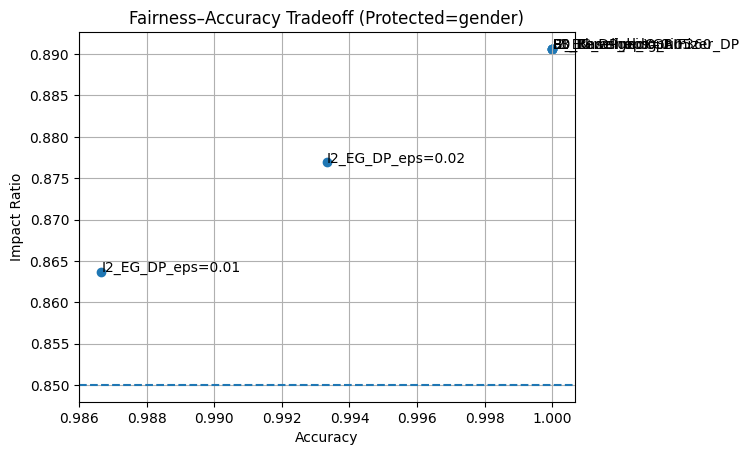

In [ ]:
plt.figure()
plt.scatter(results_df["Accuracy"], results_df["Impact_Ratio"])
for _, r in results_df.iterrows():
    plt.annotate(r["Model"], (r["Accuracy"], r["Impact_Ratio"]))
plt.axhline(0.85, linestyle="--")
plt.xlabel("Accuracy")
plt.ylabel("Impact Ratio")
plt.title(f"Fairness–Accuracy Tradeoff (Protected={PROTECTED})")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_from_predictions(y_true, pred_a, pred_b):
    y_true = np.asarray(y_true)
    pred_a = np.asarray(pred_a)
    pred_b = np.asarray(pred_b)

    a_correct = (pred_a == y_true)
    b_correct = (pred_b == y_true)

    both_wrong = np.sum(~a_correct & ~b_correct)
    a_wrong_b_right = np.sum(~a_correct &  b_correct)
    a_right_b_wrong = np.sum( a_correct & ~b_correct)
    both_right = np.sum( a_correct &  b_correct)

    table = np.array([[both_wrong, a_wrong_b_right],
                      [a_right_b_wrong, both_right]])

    return table, a_wrong_b_right, a_right_b_wrong

table, b, c = mcnemar_from_predictions(y_test.values, y_pred_base, y_pred_th)
print("McNemar 2x2 table:\n", table)
print("b (A wrong, B right) =", b)
print("c (A right, B wrong) =", c)

if b + c == 0:
    print("McNemar test not applicable: models have identical correctness on all samples (no disagreements).")
else:
    print(mcnemar(table, exact=True))


McNemar 2x2 table:
 [[  0   0]
 [  0 150]]
b (A wrong, B right) = 0
c (A right, B wrong) = 0
McNemar test not applicable: models have identical correctness on all samples (no disagreements).


In [1]:
results_df.to_csv("task1_results_with_jd.csv", index=False)
print("Saved: task1_results_with_jd.csv")


NameError: name 'results_df' is not defined